### Carregando as bibliotecas necessária

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPool2D ,AveragePooling2D
from keras.layers import Dense, Dropout, Flatten 
from keras.layers import BatchNormalization

from keras.preprocessing.image import ImageDataGenerator

from keras.utils.np_utils import to_categorical

Neste projeto iremos usar a GPU para fazer o processamento, então a seguir iremos definir para o tensoflow usar a gpu e depois iremos limitar a memoria vram da gpu para evitar problemas.

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [13]:
gpu_opts = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.4)
Sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_opts))

### Carregaando conjunto de dados

In [4]:
train,test,sub = pd.read_csv('train.csv'), pd.read_csv('test.csv'),pd.read_csv('sample_submission.csv')

In [5]:
x_train,y_train=train.drop('label',axis=1),train['label']

Vamos ajusta a escala para ficar entre 0 e 1 e depois vamos estruturar o conjunto de dados

In [6]:
x_train/=255.0
test/=255.0

In [7]:
x_train = x_train.values.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

A seguir vamos plotar as imagens com suas respectivas categorias

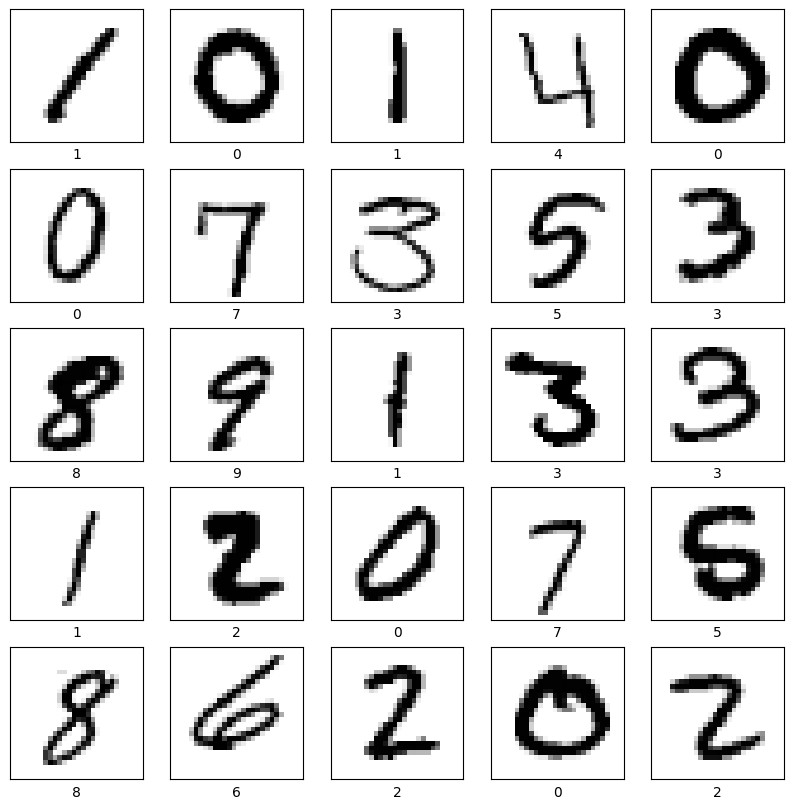

In [8]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
plt.show()

In [9]:
y_train = to_categorical(y_train, num_classes = 10)

In [10]:
X_train, X_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.1, shuffle=True,random_state=42)

In [11]:
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((37800, 28, 28, 1), (4200, 28, 28, 1), (37800, 10), (4200, 10))

In [20]:
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 158, kernel_size = (5,5), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 158, kernel_size = (3,3), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (2,2), activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Conv2D(filters = 10, kernel_size = (2,2),padding = 'Same' , activation ='relu'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
#model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))
    
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 28, 28, 64)        1664      
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 24, 24, 158)       252958    
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 12, 12, 158)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 10, 10, 158)       224834    
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 5, 5, 158)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 4, 4, 64)          40512     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 2, 2, 64)         

In [22]:
rp = keras.callbacks.ReduceLROnPlateau(
        monitor="val_acc",
        factor=0.2,
        patience=3,
        verbose=1,
        mode="max",
        min_lr=0.000001,
     )
history = model.fit(X_train, y_train, steps_per_epoch=len(X_train)/100, 
                    epochs=50, validation_data=(X_val, y_val), callbacks=[rp])

Epoch 1/50
378/378 [==============================] - 19s 41ms/step - loss: 0.1646 - accuracy: 0.9484 - val_loss: 0.1671 - val_accuracy: 0.9471
Epoch 2/50
378/378 [==============================] - 15s 39ms/step - loss: 0.0522 - accuracy: 0.9838 - val_loss: 0.4444 - val_accuracy: 0.8650
Epoch 3/50
378/378 [==============================] - 15s 38ms/step - loss: 0.0382 - accuracy: 0.9874 - val_loss: 0.0409 - val_accuracy: 0.9890
Epoch 4/50
378/378 [==============================] - 15s 39ms/step - loss: 0.0293 - accuracy: 0.9904 - val_loss: 0.0674 - val_accuracy: 0.9805
Epoch 5/50
378/378 [==============================] - 15s 39ms/step - loss: 0.0268 - accuracy: 0.9915 - val_loss: 0.0944 - val_accuracy: 0.9726
Epoch 6/50
378/378 [==============================] - 15s 39ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0765 - val_accuracy: 0.9779
Epoch 7/50
378/378 [==============================] - 15s 39ms/step - loss: 0.0159 - accuracy: 0.9949 - val_loss: 0.0522 - val_accuracy:

#### -------

In [23]:
X_test = np.array(test)
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
Y_test = model.predict(X_test)

In [24]:
Y_test = np.argmax(Y_test, axis=1)
sub['Label']=Y_test
sub.head(10)

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,9
4,5,3
5,6,7
6,7,0
7,8,3
8,9,0
9,10,3


In [25]:
sub.to_csv('submission.csv', index=False)